In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import tarfile
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split

#Работа с данными

###Загрузка и распаковка датасета

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz"
download_url(dataset_url, '.')

100%|██████████| 135107811/135107811 [00:02<00:00, 47781773.43it/s]


In [4]:
with tarfile.open('./cifar10.tgz', 'r:gz') as tar:
    tar.extractall(path='./data')


In [5]:
data_dir = './data/cifar10'

print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/train")
print(classes)

['test', 'train']
['bird', 'truck', 'dog', 'ship', 'cat', 'deer', 'airplane', 'automobile', 'horse', 'frog']


In [6]:
# Преобразование в тензор
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
dataset = ImageFolder(data_dir+'/train', transform=ToTensor())


In [7]:
img, label = dataset[0]
print(img.shape, label)
img

torch.Size([3, 32, 32]) 0


tensor([[[0.7922, 0.7922, 0.8000,  ..., 0.8118, 0.8039, 0.7961],
         [0.8078, 0.8078, 0.8118,  ..., 0.8235, 0.8157, 0.8078],
         [0.8235, 0.8275, 0.8314,  ..., 0.8392, 0.8314, 0.8235],
         ...,
         [0.8549, 0.8235, 0.7608,  ..., 0.9529, 0.9569, 0.9529],
         [0.8588, 0.8510, 0.8471,  ..., 0.9451, 0.9451, 0.9451],
         [0.8510, 0.8471, 0.8510,  ..., 0.9373, 0.9373, 0.9412]],

        [[0.8000, 0.8000, 0.8078,  ..., 0.8157, 0.8078, 0.8000],
         [0.8157, 0.8157, 0.8196,  ..., 0.8275, 0.8196, 0.8118],
         [0.8314, 0.8353, 0.8392,  ..., 0.8392, 0.8353, 0.8275],
         ...,
         [0.8510, 0.8196, 0.7608,  ..., 0.9490, 0.9490, 0.9529],
         [0.8549, 0.8471, 0.8471,  ..., 0.9412, 0.9412, 0.9412],
         [0.8471, 0.8431, 0.8471,  ..., 0.9333, 0.9333, 0.9333]],

        [[0.7804, 0.7804, 0.7882,  ..., 0.7843, 0.7804, 0.7765],
         [0.7961, 0.7961, 0.8000,  ..., 0.8039, 0.7961, 0.7882],
         [0.8118, 0.8157, 0.8235,  ..., 0.8235, 0.8157, 0.

In [10]:
print(dataset.classes[0])

airplane


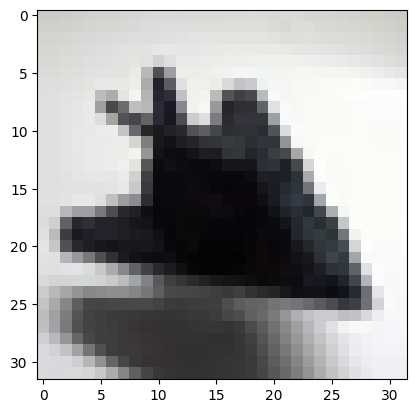

In [11]:
import matplotlib
import matplotlib.pyplot as plt
plt.imshow(img.permute(1, 2, 0))

###Dataloaders

In [12]:
len(dataset)

50000

In [60]:
random_seed = 42
torch.manual_seed(random_seed)

val_size = 5000
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(45000, 5000)

In [61]:
from torch.utils.data.dataloader import DataLoader

batch_size=128

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)



#Создание CNN Модели

In [62]:
# max_acc = 0
class ImageClassificationBase(nn.Module):
    # max_acc = 0

    def training_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        # if epoch_acc > max_acc:
        #   print("-------------Сохраниение модели-------------")
        #   max_acc = epoch_acc
        # # torch.save(model, '/content/drive/MyDrive/Colab Notebooks/УИРС/cifar_CNN_model.pth')
        #   torch.save(model, '/content/drive/MyDrive/Colab Notebooks/cifar_CNN_model.pth')

        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        max_acc = 0
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [63]:
class Cifar10CnnModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4

            nn.Flatten(),
            nn.Linear(256*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10))

    def forward(self, xb):
        return self.network(xb)

In [64]:
model = Cifar10CnnModel()
model

Cifar10CnnModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=4096, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_feat

In [65]:
for images, labels in train_dl:
    print('images.shape:', images.shape)
    out = model(images)
    print('out.shape:', out.shape)
    print('out[0]:', out[0])
    break

images.shape: torch.Size([128, 3, 32, 32])
out.shape: torch.Size([128, 10])
out[0]: tensor([-0.0196,  0.0411, -0.0260, -0.0372,  0.0459, -0.0270, -0.0140,  0.0326,
         0.0288,  0.0188], grad_fn=<SelectBackward0>)


In [66]:
# Функции для выбора устройства
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [67]:
device = get_default_device()
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device);
device

device(type='cuda')

###Обучение CNN

In [68]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [69]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.001

In [70]:
import time
start_time = time.time()
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)
end_time = time.time()
print("Время обучения:", end_time - start_time)

Epoch [0], train_loss: 1.8805, val_loss: 1.5404, val_acc: 0.4281
Epoch [1], train_loss: 1.3780, val_loss: 1.2504, val_acc: 0.5462
Epoch [2], train_loss: 1.0924, val_loss: 0.9748, val_acc: 0.6550
Epoch [3], train_loss: 0.9014, val_loss: 0.8771, val_acc: 0.6886
Epoch [4], train_loss: 0.7786, val_loss: 0.8868, val_acc: 0.6894
Epoch [5], train_loss: 0.6691, val_loss: 0.7618, val_acc: 0.7345
Epoch [6], train_loss: 0.5763, val_loss: 0.8005, val_acc: 0.7265
Epoch [7], train_loss: 0.5011, val_loss: 0.7365, val_acc: 0.7588
Epoch [8], train_loss: 0.4300, val_loss: 0.7848, val_acc: 0.7446
Epoch [9], train_loss: 0.3628, val_loss: 0.7981, val_acc: 0.7562
Время обучения: 168.22694206237793


In [ ]:
# weights = torch.load('/content/drive/MyDrive/Colab Notebooks/cifar_CNN_model.pth')#, map_location=torch.device('cpu'))
# model.load_state_dict(weights.state_dict())

In [71]:
model.eval()
start_time = time.time()
result = evaluate(model, val_dl)
end_time = time.time()
print(result)
print("Время валидации:", end_time - start_time)

{'val_loss': 0.7981192469596863, 'val_acc': 0.7562270164489746}
Время валидации: 2.473020076751709


#AlexNet

## Преобразования данных для подачи на вход модели AlexNet

In [93]:
import torchvision as tv

transform = tv.transforms.Compose([
    tv.transforms.Resize((224, 224)),
])

# Создание DataLoader с применением трансформаций
class TransformDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

# Создание DataLoader с трансформацией
train_dataset = TransformDataset(train_ds, transform=transform)
val_dataset = TransformDataset(val_ds, transform=transform)

In [94]:
batch_size = 64
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last = True, num_workers=4)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, num_workers=4)

In [95]:
for digit, label in train_dataloader:
  print(digit.shape)
  print(label.shape)
  break


torch.Size([64, 3, 224, 224])
torch.Size([64])


In [96]:
device  = "cuda" if torch.cuda.is_available() else "cpu"
# device  = "cpu"
device

'cuda'

In [102]:
model = tv.models.alexnet(pretrained=True).to(device)
print(model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [103]:
for param in model.parameters():
  param.requires_grad = False

# Новый классификатор
classifier = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(9216, 4096),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(4096, 4096),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(4096, 1000),
    nn.ReLU(),
    nn.Linear(1000, 10)
)
model.classifier = classifier
model.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [104]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.classifier.parameters(), lr=0.0075, momentum=0.9)

In [105]:
def accuracy (prediction, label):
  answer = F.softmax(prediction.detach()).numpy().argmax(1) == label.numpy().argmax(1)
  # равны ли индексы максимальных элементов
  # print(answer)
  # print(answer.sum())
  return answer.mean()

In [106]:
import time
from tqdm.autonotebook import tqdm

max_acc = 0
model = model.to(device)
loss_fn = loss_fn.to(device)

epochs = 6
start_time = time.time()
for e in range(epochs):

  model.train()

  loss_train = 0
  acc_train = 0

  for digit, label in tqdm(train_dataloader):
    optimizer.zero_grad()

    digit = digit.to(device)
    label = label.to(device)

    # превращение label в вектор вероятностей (3 -> 00010000000)
    label = label.long() # так как аргумент one_hot должен быть целым
    label = F.one_hot(label, 10).float()

    # digit = digit.views(-1, 28*28)

    prediction = model(digit)

    loss = loss_fn(prediction, label)
    loss.backward() #подсчёт градиентов
    loss_train += loss.item()

    optimizer.step()

    acc_train += accuracy(prediction.cpu(), label.cpu())

  # Валидация модели после обучения на каждой эпохе
  acc_val = 0

  model.eval()

  for digit, label in val_dataloader:
      digit = digit.to(device)
      label = label.to(device)

      # превращение label в вектор вероятностей (3 -> 00010000000)
      label = label.long() # так как аргумент one_hot должен быть целым
      label = F.one_hot(label, 10).float()

      prediction = model(digit)

      acc_val += accuracy(prediction.cpu(), label.cpu())

  if (acc_val/len(val_dataloader)) > max_acc:
      print("-------------Сохраниение модели-------------")
      max_acc = acc_val/len(val_dataloader)
      # torch.save(model, '/content/drive/MyDrive/Colab Notebooks/УИРС/cifar_alexnet_model.pth')
      torch.save(model, '/content/drive/MyDrive/Colab Notebooks/cifar_alexnet_model.pth')

  print(f'epoch: {e}, looss: {loss_train/len(train_dataloader)}, accuracy: {acc_train/len(train_dataloader)}')
  print(f'Accuracy val: {acc_val/len(val_dataloader)}')
end_time = time.time()
print("Время обучения:", end_time - start_time)

  0%|          | 0/703 [00:00<?, ?it/s]

<ipython-input-105-d9b1963dfb08>:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  answer = F.softmax(prediction.detach()).numpy().argmax(1) == label.numpy().argmax(1)


-------------Сохраниение модели-------------
epoch: 0, looss: 1.3912776009965249, accuracy: 0.49019825746799434
Accuracy val: 0.6428006329113924


  0%|          | 0/703 [00:00<?, ?it/s]

-------------Сохраниение модели-------------
epoch: 1, looss: 1.021047581225676, accuracy: 0.6366242887624467
Accuracy val: 0.7029272151898734


  0%|          | 0/703 [00:00<?, ?it/s]

-------------Сохраниение модели-------------
epoch: 2, looss: 0.9377202579001783, accuracy: 0.6693189900426743
Accuracy val: 0.7225079113924051


  0%|          | 0/703 [00:00<?, ?it/s]

-------------Сохраниение модели-------------
epoch: 3, looss: 0.8882704871477477, accuracy: 0.6865887268847796
Accuracy val: 0.7401107594936709


  0%|          | 0/703 [00:00<?, ?it/s]

-------------Сохраниение модели-------------
epoch: 4, looss: 0.8555670394158126, accuracy: 0.7013691322901849
Accuracy val: 0.7403085443037974


  0%|          | 0/703 [00:00<?, ?it/s]

-------------Сохраниение модели-------------
epoch: 5, looss: 0.822792680131253, accuracy: 0.7090149359886202
Accuracy val: 0.7480221518987342
Время обучения: 537.0001153945923


lr=0.01, ep = 5, время 565, точность 0.754<br>
lr=0.01, ep = 5, num_workers=4, время 436, точность  0.737<br>
lr=0.005, ep = 6, num_workers=4, время 523, точность  0.746

#Полносвязная сеть

In [8]:
img, label = dataset[0]
print(img.shape, label)
img

torch.Size([3, 32, 32]) 0


tensor([[[0.7922, 0.7922, 0.8000,  ..., 0.8118, 0.8039, 0.7961],
         [0.8078, 0.8078, 0.8118,  ..., 0.8235, 0.8157, 0.8078],
         [0.8235, 0.8275, 0.8314,  ..., 0.8392, 0.8314, 0.8235],
         ...,
         [0.8549, 0.8235, 0.7608,  ..., 0.9529, 0.9569, 0.9529],
         [0.8588, 0.8510, 0.8471,  ..., 0.9451, 0.9451, 0.9451],
         [0.8510, 0.8471, 0.8510,  ..., 0.9373, 0.9373, 0.9412]],

        [[0.8000, 0.8000, 0.8078,  ..., 0.8157, 0.8078, 0.8000],
         [0.8157, 0.8157, 0.8196,  ..., 0.8275, 0.8196, 0.8118],
         [0.8314, 0.8353, 0.8392,  ..., 0.8392, 0.8353, 0.8275],
         ...,
         [0.8510, 0.8196, 0.7608,  ..., 0.9490, 0.9490, 0.9529],
         [0.8549, 0.8471, 0.8471,  ..., 0.9412, 0.9412, 0.9412],
         [0.8471, 0.8431, 0.8471,  ..., 0.9333, 0.9333, 0.9333]],

        [[0.7804, 0.7804, 0.7882,  ..., 0.7843, 0.7804, 0.7765],
         [0.7961, 0.7961, 0.8000,  ..., 0.8039, 0.7961, 0.7882],
         [0.8118, 0.8157, 0.8235,  ..., 0.8235, 0.8157, 0.

In [9]:
class LnCIFAR(nn.Module):
  def __init__(self, prob):
    super().__init__()
    self.flat = nn.Flatten()
    self.l1 = nn.Linear(3*32*32, 1000)
    self.l2 = nn.Linear(1000, 400)
    self.l3 = nn.Linear(400, 10)
    self.dropout = nn.Dropout(p=prob)

    self.act_fn = nn.ReLU()

  def forward(self, x):
    x = self.flat(x)
    x = self.l1(self.dropout(x))
    x = self.act_fn(x)
    x = self.l2(self.dropout(x))
    x = self.act_fn(x)
    x = self.l3(x)

    return x

In [10]:
random_seed = 42
torch.manual_seed(random_seed)

val_size = 5000
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(45000, 5000)

In [13]:
batch_size = 50
train_dataloader = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True, drop_last = True)
val_dataloader = torch.utils.data.DataLoader(val_ds, batch_size=batch_size)

In [14]:
for digit, label in train_dataloader:
  print(digit.shape)
  print(label.shape)
  break

torch.Size([50, 3, 32, 32])
torch.Size([50])


In [21]:
p = 0.25
model = LnCIFAR(p)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [22]:
def accuracy (prediction, label):
  answer = F.softmax(prediction.detach()).numpy().argmax(1) == label.numpy().argmax(1)
  return answer.mean()

max_acc = 0

In [23]:
device  = "cuda" if torch.cuda.is_available() else "cpu"
# device  = "cpu"
device

'cuda'

In [24]:
from tqdm import tqdm
import time

model = model.to(device)
loss_fn = loss_fn.to(device)

epochs = 20
start_time = time.time()
for e in range(epochs):

  model.train()

  loss_train = 0
  acc_train = 0

  for digit, label in tqdm(train_dataloader):
    optimizer.zero_grad()

    digit = digit.to(device)
    label = label.to(device)

    # превращение label в вектор вероятностей (3 -> 00010000000)
    label = label.long() # так как аргумент one_hot должен быть целым
    label = F.one_hot(label, 10).float()

    prediction = model(digit)

    loss = loss_fn(prediction, label)
    loss.backward() #подсчёт градиентов
    loss_train += loss.item()

    optimizer.step()

    acc_train += accuracy(prediction.cpu(), label.cpu())

  # Валидация модели после обучения на каждой эпохе
  acc_val = 0

  model.eval()

  for digit, label in val_dataloader:
      digit = digit.to(device)
      label = label.to(device)

      # превращение label в вектор вероятностей (3 -> 00010000000)
      label = label.long() # так как аргумент one_hot должен быть целым
      label = F.one_hot(label, 10).float()

      prediction = model(digit)

      acc_val += accuracy(prediction.cpu(), label.cpu())

  if (acc_val/len(val_dataloader)) > max_acc:
      print("-------------Сохраниение модели-------------")
      max_acc = acc_val/len(val_dataloader)
      # torch.save(model, '/content/drive/MyDrive/ML/ML_files/mnist_model.pth')
      torch.save(model, '/content/drive/MyDrive/Colab Notebooks/cifar_LN_model.pth')

  print(f'epoch: {e}, looss: {loss_train/len(train_dataloader)}, accuracy: {acc_train/len(train_dataloader)}')
  print(f'Accuracy val: {acc_val/len(val_dataloader)}')
end_time = time.time()
print("Время обучения:", end_time - start_time)

  0%|          | 0/900 [00:00<?, ?it/s]<ipython-input-22-c0f4bbb4a3a8>:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  answer = F.softmax(prediction.detach()).numpy().argmax(1) == label.numpy().argmax(1)
100%|██████████| 900/900 [00:20<00:00, 44.83it/s]


-------------Сохраниение модели-------------
epoch: 0, looss: 2.1255374058087666, accuracy: 0.22195555555555568
Accuracy val: 0.28680000000000017


100%|██████████| 900/900 [00:18<00:00, 49.55it/s]


-------------Сохраниение модели-------------
epoch: 1, looss: 1.9124439843495686, accuracy: 0.31819999999999987
Accuracy val: 0.34180000000000016


100%|██████████| 900/900 [00:19<00:00, 45.10it/s]


-------------Сохраниение модели-------------
epoch: 2, looss: 1.8363394561078814, accuracy: 0.3463777777777772
Accuracy val: 0.3630000000000001


100%|██████████| 900/900 [00:18<00:00, 49.50it/s]


-------------Сохраниение модели-------------
epoch: 3, looss: 1.7789770046869913, accuracy: 0.3699999999999999
Accuracy val: 0.37740000000000007


100%|██████████| 900/900 [00:19<00:00, 46.88it/s]


-------------Сохраниение модели-------------
epoch: 4, looss: 1.7389704382419586, accuracy: 0.3800888888888885
Accuracy val: 0.3852000000000001


100%|██████████| 900/900 [00:18<00:00, 49.84it/s]


-------------Сохраниение модели-------------
epoch: 5, looss: 1.7054482691817814, accuracy: 0.39188888888888784
Accuracy val: 0.4072000000000001


100%|██████████| 900/900 [00:19<00:00, 45.07it/s]


-------------Сохраниение модели-------------
epoch: 6, looss: 1.6757697078916762, accuracy: 0.4051555555555545
Accuracy val: 0.4134


100%|██████████| 900/900 [00:18<00:00, 49.44it/s]


-------------Сохраниение модели-------------
epoch: 7, looss: 1.6467256605625153, accuracy: 0.415888888888888
Accuracy val: 0.4364000000000005


100%|██████████| 900/900 [00:19<00:00, 46.76it/s]


epoch: 8, looss: 1.6253455024295382, accuracy: 0.42242222222222076
Accuracy val: 0.43000000000000005


100%|██████████| 900/900 [00:19<00:00, 46.64it/s]


-------------Сохраниение модели-------------
epoch: 9, looss: 1.6078420163525475, accuracy: 0.4283999999999991
Accuracy val: 0.43699999999999994


100%|██████████| 900/900 [00:19<00:00, 46.70it/s]


-------------Сохраниение модели-------------
epoch: 10, looss: 1.584171396891276, accuracy: 0.44057777777777674
Accuracy val: 0.4512000000000001


100%|██████████| 900/900 [00:18<00:00, 49.29it/s]


-------------Сохраниение модели-------------
epoch: 11, looss: 1.5650725071960025, accuracy: 0.44546666666666584
Accuracy val: 0.45240000000000014


100%|██████████| 900/900 [00:19<00:00, 46.46it/s]


-------------Сохраниение модели-------------
epoch: 12, looss: 1.5556115402115716, accuracy: 0.4475555555555549
Accuracy val: 0.45720000000000005


100%|██████████| 900/900 [00:18<00:00, 49.35it/s]


-------------Сохраниение модели-------------
epoch: 13, looss: 1.5384270188543532, accuracy: 0.4542888888888882
Accuracy val: 0.468


100%|██████████| 900/900 [00:19<00:00, 47.03it/s]


-------------Сохраниение модели-------------
epoch: 14, looss: 1.5241121813986036, accuracy: 0.45873333333333244
Accuracy val: 0.47240000000000004


100%|██████████| 900/900 [00:18<00:00, 49.35it/s]


epoch: 15, looss: 1.512438017792172, accuracy: 0.4619111111111101
Accuracy val: 0.4678


100%|██████████| 900/900 [00:18<00:00, 47.53it/s]


-------------Сохраниение модели-------------
epoch: 16, looss: 1.495205035077201, accuracy: 0.46951111111111093
Accuracy val: 0.47439999999999993


100%|██████████| 900/900 [00:18<00:00, 49.79it/s]


epoch: 17, looss: 1.4879947519302368, accuracy: 0.4712444444444437
Accuracy val: 0.4561999999999999


100%|██████████| 900/900 [00:18<00:00, 48.28it/s]


-------------Сохраниение модели-------------
epoch: 18, looss: 1.4758136116133795, accuracy: 0.4741777777777771
Accuracy val: 0.48979999999999996


100%|██████████| 900/900 [00:19<00:00, 46.56it/s]


epoch: 19, looss: 1.4719341572125753, accuracy: 0.4751777777777774
Accuracy val: 0.48620000000000013
Время обучения: 413.39726996421814


In [27]:
# Загрузка весов сохраённой модели
weights = torch.load('/content/drive/MyDrive/Colab Notebooks/cifar_LN_model.pth')
model.load_state_dict(weights.state_dict())

<All keys matched successfully>

In [28]:
acc_val = 0

model.eval()

for digit, label in val_dataloader:
    digit = digit.to(device)
    label = label.to(device)

    # превращение label в вектор вероятностей (3 -> 00010000000)
    label = label.long() # так как аргумент one_hot должен быть целым
    label = F.one_hot(label, 10).float()

    prediction = model(digit)

    acc_val += accuracy(prediction.cpu(), label.cpu())

print(f'accuracy: {acc_val/len(val_dataloader)}')

<ipython-input-22-c0f4bbb4a3a8>:2: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  answer = F.softmax(prediction.detach()).numpy().argmax(1) == label.numpy().argmax(1)


accuracy: 0.48979999999999996
